In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import helper.helper as h
import statsmodels.api as sm
from tqdm import tqdm

In [6]:
def ols_W(X, P):
    # translate X
    x = X @ P.T

    # get regressor and varibles
    y = x[1:]
    x = x[:-1]

    W_hat = np.array(np.zeros(p)).T

    # get parameters
    for i in range(p):
        est = sm.OLS(y[:, i], x[:, :(i + 1)]).fit()   
        W_hat = np.vstack((W_hat, np.append(est.params, np.zeros(p - (i + 1))).T))

    return P.T @ W_hat[1:].T @ P

In [7]:
def generate_U(p, num_edges, low = 0.5, high = 2.0, tril = False):
    edges = np.array([0.0] * (int(p * (p + 1) / 2) - num_edges - p * tril) + [1.0] * num_edges)
    
    edges[edges > 0] = (2 * np.random.randint(0, 2, size=(num_edges)) - 1) * np.random.uniform(low, high, num_edges)
    np.random.shuffle(edges)
    
    U = np.zeros((p, p))
    
    U[np.tril_indices(p, - tril)] = edges
    
    return U

U:
[[ 0.5  -1.35  0.    1.52  0.  ]
 [ 0.    0.5   0.76  0.    0.  ]
 [ 0.    0.    0.5   0.    0.54]
 [ 0.    0.    0.    0.5   1.39]
 [ 0.    0.    0.    0.    0.5 ]]

P:
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]].
[[ 0.5         0.         -1.35419597  1.52024842  0.        ]
 [ 0.          0.5         0.          0.          0.        ]
 [ 0.          0.          0.5         0.          0.75921977]
 [ 0.          1.39477761  0.          0.5         0.        ]
 [ 0.          0.53694244  0.          0.          0.5       ]]
[[ 0.54089914  0.07663856 -1.19697033  1.52202963  0.21404087]
 [ 0.          0.4828669   0.          0.          0.        ]
 [ 0.         -0.04171189  0.52736765 -0.16550134  0.77158607]
 [ 0.          1.3334573   0.          0.44974504  0.        ]
 [ 0.          0.50934279  0.          0.10447505  0.52160664]]


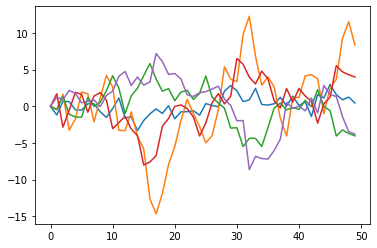

In [8]:
## Number of dimensions, number of edges, number of samples
T, p, s = 50, 5, 5

## Coefficient matrix
U_true = generate_U(p, s, tril = True).T
for i in range(p):
    U_true[i][i] = 0.5

## True permutation
P_true = np.random.permutation(np.identity(p))

## Generate series
X = h.generate_var_2(T, p, U_true, P_true)
plt.plot(X);

print(f"U:\n{np.round(U_true, 2)}\n\nP:\n{P_true}.")

print(P_true.T @ U_true @ P_true)

print(ols_W(X, P_true))

In [9]:
def sample_next_P(P):  
    # get copy
    P_return = P.copy()
    
    # get the two rows to swap
    i, j = np.random.choice(p, 2, replace = False)
    
    # swap row i and row j
    P_return[[i, j]] = P_return[[j, i]]
    
    # return new sample
    return P_return

In [10]:
def loss(W, X):
    return 1 / (T - 1) * np.linalg.norm(X[1:] - X[:-1] @ W, 'f') ** 2

def get_likelihood(P):
    # get optimal A for this permutation
    W_opt = ols_W(X, P)

    # get loss    
    return loss(W_opt, X)

print(ols_W(X, P_true))
O = np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:]
min_likelihood = loss(O, X)
print(loss(ols_W(X, P_true), X))

[[ 0.54089914  0.07663856 -1.19697033  1.52202963  0.21404087]
 [ 0.          0.4828669   0.          0.          0.        ]
 [ 0.         -0.04171189  0.52736765 -0.16550134  0.77158607]
 [ 0.          1.3334573   0.          0.44974504  0.        ]
 [ 0.          0.50934279  0.          0.10447505  0.52160664]]
5.1053581828381205


In [39]:
L_ols = loss(np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:], X)
k = 2

def acc_prob_reg(L, L_new):
    return min(L / L_new, 1)

def acc_prob_trans(L, L_new, L_ols = L_ols):
    return min((L - L_ols) / (L_new - L_ols), 1)

def acc_prob_pow(L, L_new, k = k):
    return min((L / L_new) ** k, 1)

def acc_prob_trans_pow(L, L_new, k = k, L_ols = L_ols):
    return min(((L - L_ols) / (L_new - L_ols)) ** k, 1)

def acc_prob_greed(L, L_new, k = k, L_ols = L_ols):
    return L_new < L

def mcmc(max_it, verbose = False, P = np.identity(p), factor = 1.0, acc_prob = acc_prob_reg):
    # smallest likelihood
    min_likelihood = 0 # loss(np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:], X)
    
    # initial value
    likelihood_P = get_likelihood(P) - min_likelihood

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_l_iter = []
    results_l_transition = []
    results_l_next = []
    num_missed_edges = []

    # transitions
    transitions = 0
    
    for i in tqdm(range(max_it)):   
        # sample next P
        P_prime = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P_prime = get_likelihood(P_prime)
        alpha = acc_prob(likelihood_P, likelihood_P_prime)
        
        # print results
        if verbose:
            print(f"Iteration {i+1}.\n")
            print(f"Old P:\n{P}\nLikelihood: {round(likelihood_P, 2)}\n\nNew P:\n{P_prime}\nLikelihood: {round(likelihood_P_prime, 2)}.")
            print(f"\nAcceptance probability: {round(alpha, 3)}.")
    
        # prepare for next iteration
        if np.random.rand() <= alpha:
            transitions += 1
            P, likelihood_P = P_prime, likelihood_P_prime
            results_l_transition.append(likelihood_P_prime)
            # save best
            if likelihood_P < L_best:
                L_best = likelihood_P
                P_best = P
        
        # results
        results_l_next.append(likelihood_P_prime)
        results_likelihood.append(L_best)
        results_l_iter.append(likelihood_P)
        check_triu = np.triu(P_best @ P_true.T @ U_true @ P_true @ P_best.T)
        num_missed_edges.append(len(check_triu[check_triu != 0]))
    
    print(transitions)
    print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")
    return P_best, [results_l_iter, results_likelihood, results_l_transition, results_l_next, num_missed_edges]

def rw(max_it, verbose = False, P = np.identity(p), factor = 1.0):
    # initial value
    likelihood_P = get_likelihood(P)

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_l_iter = []
    num_missed_edges = []
    for i in tqdm(range(max_it)):   
        # sample next P
        P = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P = get_likelihood(P)
        
        # save best
        if likelihood_P < L_best:
            L_best = likelihood_P
            P_best = P
                
        results_likelihood.append(L_best)
        results_l_iter.append(likelihood_P)
        check_triu = np.triu(P_best @ P_true.T @ U_true @ P_true @ P_best.T)
        num_missed_edges.append(len(check_triu[check_triu != 0]))
    
    print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")
    return P_best, [results_l_iter, results_likelihood, num_missed_edges]

In [55]:
np.random.seed(seed = 11)

## Number of dimensions, number of edges, number of samples
T, p, s = 100, 10, 10

## Coefficient matrix
U_true = generate_U(p, s, tril = True).T
for i in range(p):
    U_true[i][i] = 0.5

## True permutation
P_true = np.random.permutation(np.identity(p))

## Generate series
X = h.generate_var_2(T, p, U_true, P_true)

np.random.seed(seed = 123)
P, r = mcmc(360, False, acc_prob = acc_prob_reg)
np.random.seed(seed = 123)
Prt, rt = mcmc(360, False, acc_prob = acc_prob_trans)
np.random.seed(seed = 123)
Prp, rp = mcmc(360, False, acc_prob = acc_prob_pow)
np.random.seed(seed = 123)
Prtp, rtp = mcmc(360, False, acc_prob = acc_prob_trans_pow)
np.random.seed(seed = 123)
Prtg, rg = mcmc(360, False, acc_prob = acc_prob_greed)
np.random.seed(seed = 123)
rwP, rw_l = rw(360, False)

  6%|████▍                                                                           | 20/360 [00:00<00:01, 199.94it/s]

340
Best permutation:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

Likelihood: 9.39.


  6%|████▍                                                                           | 20/360 [00:00<00:01, 198.02it/s]

299
Best permutation:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

Likelihood: 10.35.


  5%|████                                                                            | 18/360 [00:00<00:01, 175.48it/s]

309
Best permutation:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

Likelihood: 9.33.


  5%|████                                                                            | 18/360 [00:00<00:01, 176.58it/s]

177
Best permutation:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

Likelihood: 9.37.


  5%|████▏                                                                           | 19/360 [00:00<00:01, 181.14it/s]

21
Best permutation:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

Likelihood: 9.33.


100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:02<00:00, 173.01it/s]

Best permutation:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

Likelihood: 9.42.


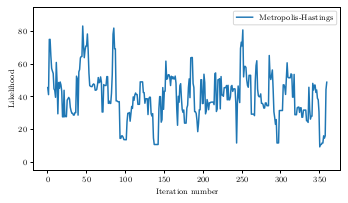

In [91]:
fig = plt.figure(figsize = (5.5, 3))
plt.ylim(-5, 95)
plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(np.array(r[0]), label = "Metropolis-Hastings")
# plt.plot(np.array(rw_l[0]), label = "Random Walk")
plt.legend()
plt.savefig('MCMC_Ex2_plot_MCMC.pgf')

Suitable permutation found: True.
20 out of 20 edges recovered.


NameError: name 'al_list' is not defined

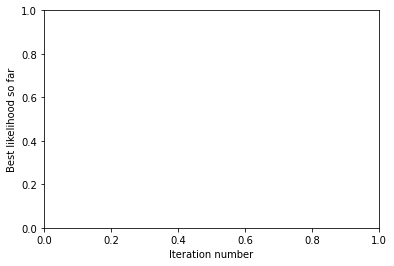

In [49]:
# verify whether the permutation is campatible
check = P @ P_true.T @ U_true @ P_true @ P.T
check_triu = np.triu(check)
print(f"Suitable permutation found: {len(check_triu[check_triu != 0]) == s + p}.")
print(f"{len(check_triu[check_triu != 0])} out of {s + p} edges recovered.")
plt.xlabel("Iteration number")
plt.ylabel("Best likelihood so far")
plt.plot(np.array(al_list) + 0)
plt.plot(rw_l_list)

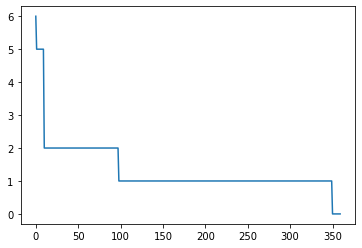

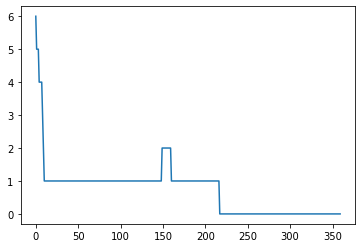

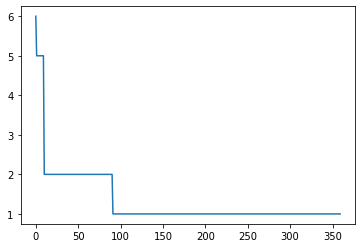

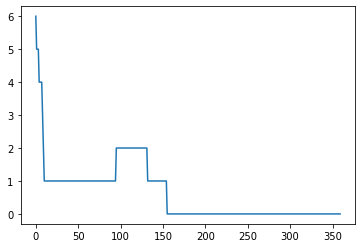

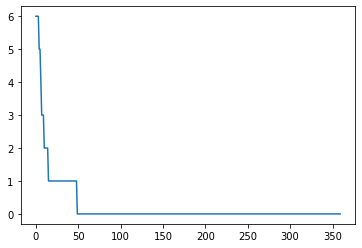

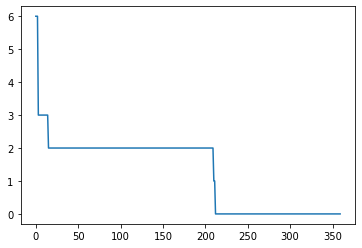

In [56]:
plt.plot(p + s - np.array(r[-1]))
plt.show()
plt.plot(p + s - np.array(rp[-1]))
plt.show()
plt.plot(p + s - np.array(rt[-1]))
plt.show()
plt.plot(p + s - np.array(rtp[-1]))
plt.show()
plt.plot(p + s - np.array(rtg[-1]))
plt.show()
plt.plot(p + s - np.array(rw_l[-1]))

In [94]:
print("Regular MCMC")
print(np.mean(np.array(r[0])))
print(np.median(np.array(r[0])))

print("Squared MCMC")
print(np.mean(np.array(rp[0])))
print(np.median(np.array(rp[0])))

print("Translated MCMC")
print(np.mean(np.array(rt[0])))
print(np.median(np.array(rt[0])))

print("Squared Translated MCMC")
print(np.mean(np.array(rtp[0])))
print(np.median(np.array(rtp[0])))

print("Greedy MCMC")
print(np.mean(np.array(rg[0])))
print(np.median(np.array(rg[0])))

print("RW")
print(np.mean(np.array(rw_l[0])))
print(np.median(np.array(rw_l[0])))

# plt.xlabel("Iteration number")
# plt.ylabel("Likelihood")
# plt.plot(r[0], label = "Normal MCMC")
# plt.legend()
# plt.savefig('MCMC_AccProb_plot_normal.pgf')
# plt.show()
# plt.plot(rp[0], label = "Squared MCMC")
# plt.legend()
# plt.savefig('MCMC_AccProb_plot_squared.pgf')
# plt.show()
# plt.plot(rt[0], label = "Translated MCMC")
# plt.legend()
# plt.savefig('MCMC_AccProb_plot_trans.pgf')
# plt.show()
# plt.plot(rtp[0], label = "Squared Translated MCMC")
# plt.legend()
# plt.savefig('MCMC_AccProb_plot_squared_trans.pgf')
# plt.show()
# plt.plot(rtg[0], label = "Greedy MCMC")
# plt.legend()
# plt.savefig('MCMC_AccProb_plot_greed.pgf')
# # plt.show()

Regular MCMC
40.52323591185325
39.87573166089305
Squared MCMC
39.038372501203476
37.11141507579744
Translated MCMC
35.98710338091739
32.23666544471769
Squared Translated MCMC
19.517106064103125
10.83928347629059
Greedy MCMC
10.724770335679146
9.407558252154864
RW
47.287579393582504
46.48785291277002


In [36]:
print("Metropolis Hastings.")
print(f"MSE incl. non-transitions")
print(f"Mean MSE:\t{round(sum(al_2_list) / len(al_2_list) + 0)}.")
print(f"Median MSE:\t{round(np.median(np.array(al_2_list) + 0))}.")

print(f"Mean MSE:\t{round(sum(l_2_list) / len(l_2_list) + min_likelihood)}.")
print(f"Median MSE:\t{round(np.median(np.array(l_2_list) + min_likelihood))}.")

print(f"MSE excl. non-transitions")
print(f"Mean MSE:\t{round(sum(al_3_list) / len(al_3_list) + 0)}.")
print(f"Median MSE:\t{round(np.median(np.array(al_3_list) + 0))}.")

print(f"MSE incl. rejected transitions")
print(f"Mean MSE:\t{round(sum(al_4_list) / len(al_4_list) + 0)}.")
print(f"Median MSE:\t{round(np.median(np.array(al_4_list) + 0))}.")

# fig = plt.figure(figsize = (3.5, 3))
plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(np.array(al_2_list) + 0, label = "Metropolis Hastings")
plt.plot(np.array(l_2_list) + min_likelihood, label = "Metropolis Hastings")
plt.legend(loc = 2)
plt.show()
plt.plot(al_3_list)
plt.show()
plt.plot(al_4_list)

Metropolis Hastings.
MSE incl. non-transitions


NameError: name 'al_2_list' is not defined

In [37]:
print("Random Walk.")
print(f"Mean MSE:\t{round(sum(rw_l_2_list) / len(rw_l_2_list))}.")
print(f"Median MSE:\t{round(np.median(np.array(rw_l_2_list)))}.")


fig = plt.figure(figsize = (3.5, 3))
plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(rw_l_2_list, label = "Random Walk")
plt.legend()

Random Walk.


NameError: name 'rw_l_2_list' is not defined

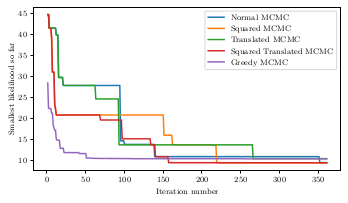

In [64]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

fig = plt.figure(figsize = (5.5, 3))
plt.xlabel("Iteration number")
plt.ylabel("Smallest likelihood so far")
plt.plot(range(1, 362), r[1], label = "Normal MCMC")
plt.plot(range(1, 362), rp[1], label = "Squared MCMC")
plt.plot(range(1, 362), rt[1], label = "Translated MCMC")
plt.plot(range(1, 362), rtp[1], label = "Squared Translated MCMC")
plt.plot(range(1, 362), rtg[1], label = "Greedy MCMC")
plt.legend()
plt.savefig('MCMC_AccProb_plot.pgf')

In [47]:
import itertools

def get_permutations(W):
    """@params: Weighted Adjacency Matrix W as numpy array"""
    # tracks the total number of permutations
    total = 0
    
    # iterate over all permutations of the identity matrix
    for perm in tqdm(itertools.permutations(np.identity(np.shape(W)[0])), total = np.math.factorial(p)):
        # convert to numpy array
        P = np.array(perm)
        
        # check if we have an upper triangular matrix
        if np.allclose(P.T @ W @ P, np.triu(P.T @ W @ P)):
            total += 1
            
    # return the number of suitable permutations
    return total

get_permutations(U_true)

100%|██████████████████████████████████████████████████████████████████████| 3628800/3628800 [15:02<00:00, 4020.79it/s]


2940